In [73]:
import html
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

# magic command. Only used in IPython and Jupyter Notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)

Populating the interactive namespace from numpy and matplotlib


## Read in the Sanitized Reddit comments. ##

I specify a datatype (referred to as dtype) for certain columns because Pandas infers the type as it reads data. If it detects that the data type has changed while reading, it will convert all previously read data into that new data type. This process is very slow and takes a lot of RAM, but Pandas will give us a nice warning telling us so we can intervene before making a computationally costly mistake.

Basically, these columns have mixed data types (maybe numeric and string), and so I must specify them manually. We do not see this in R.

Other than that, notice how similar the read data command is to R.

In [74]:
comments = pd.read_table("political_comments_clean.tsv", sep='\t',  
                         names=["username", "subreddit", "timestamp", "flair", "score", "controversial", "text"],
                         dtype={'text': object, 'flair': object})

In [75]:
comments

,username,subreddit,timestamp,flair,score,controversial,text
0,-_--_---_--_-,politics,1450539700,NaN,0,0,NaN
1,-_--_---_--_-,politics,1450581741,NaN,0,0,NaN
2,-_--_---_--_-,politics,1450582442,NaN,0,0,NaN
3,00000000000000000005,politics,1422983227,NaN,6,0,"Typo: ""2008 economic downtown"" is probably mea..."
4,00000000000000000024,politics,1463630664,NaN,1,0,"No, no he cannot."
5,00000000000000000099,politics,1479492231,NaN,0,0,Who is calling for this? I mean this guy uses ...
6,00000000000000000099,politics,1464110262,NaN,-4,1,I can't picture a scenario where either dem ca...
7,00000000000000000099,politics,1464109779,NaN,58,0,It's all fun and games until you realize he's ...
8,00000000000000000099,SandersForPresident,1464445873,NaN,-6,0,"No, not really. It's the same reason Atheists ..."
9,00000000000000000099,The_Donald,1479412116,MD,1,0,Have you ever watched the movie Wall-E? \n\nLi...


## Let's Look at Posts in the Hillary Clinton (/r/hillaryclinton) Subreddit

In [76]:
hrc_comments = comments[comments['subreddit'] == 'hillaryclinton']
hrc_comments = hrc_comments[['score', 'flair', 'controversial', 'text']]

### Our goal is to explore comment sentiment and train a classifier we can use on bigger subreddits like /r/politics. 

We will use the comment vote score to determine whether or not a comment supports, or opposes Hillary Clinton. Higher scores = more supportive, lower and negative scores = more opposing.

#### We will first check to see if the user "flair" have separate distributions of scores. Might flair be a useful feature?

Flair users are typically more involved in the community. If someone is highly involved in /r/hillaryclinton, they may be a Hillary Clinton supporter.

In [77]:
# Construct an indicator variable: has flair (1) or not (0).
hrc_comments['has_flair'] = ~pd.isnull(hrc_comments['flair'])

In [78]:
hrc_comments['has_flair'].value_counts()

True     749197
False    346225
Name: has_flair, dtype: int64

In [79]:
flair_test = hrc_comments[['has_flair', 'score']]

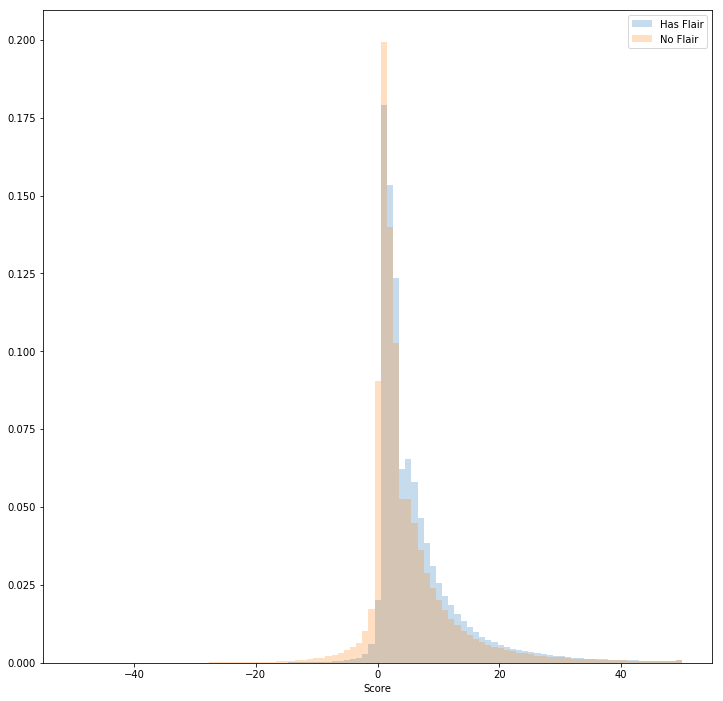

In [80]:
with_flair = flair_test['score'][flair_test['has_flair']]
no_flair = flair_test['score'][~flair_test['has_flair']]


bins = np.linspace(-50, 50, 100)

plt.hist(with_flair, bins, alpha=0.25, label='Has Flair', normed=True)
plt.hist(no_flair, bins, alpha=0.25, label='No Flair', normed=True)
plt.xlabel("Score")
plt.legend(loc='upper right')
plt.show()

This is a pretty skewed distribution. Let's try taking the log. There is a problem though. We have 0s and negative numbers. We will shift the distribution.

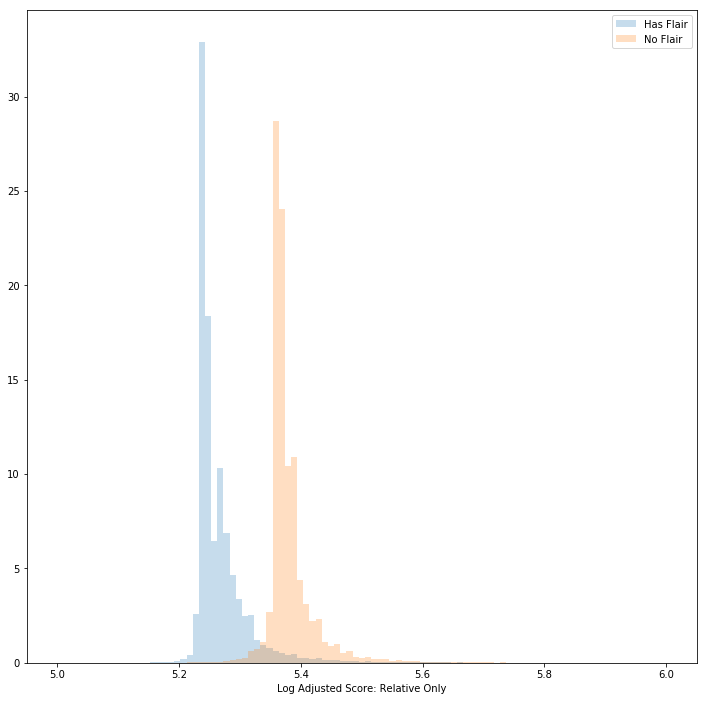

In [81]:
with_flair_log = np.log(with_flair + np.abs(min(with_flair)) + 0.001)
no_flair_log = np.log(no_flair + np.abs(min(no_flair)) + 0.001)

bins = np.linspace(5, 6, 100)

plt.hist(with_flair_log, bins, alpha=0.25, label='Has Flair', normed=True)
plt.hist(no_flair_log, bins, alpha=0.25, label='No Flair', normed=True)
plt.xlabel("Log Adjusted Score: Relative Only")
plt.legend(loc='upper right')
plt.show()

So there is indeed some difference, but it is rather negligible (about 0.2 in the log), and the relationship does not seem to make sense, so there is probably nothing interesting there. If we take this graph literally, it suggests that people WITHOUT flair have comments with higher scores.

#### OK, let's look at controversial comments

My hypothesis is that the more controversial a comment is, the less likely it is to be one that is supportive of Hillary Clinton. We will see.

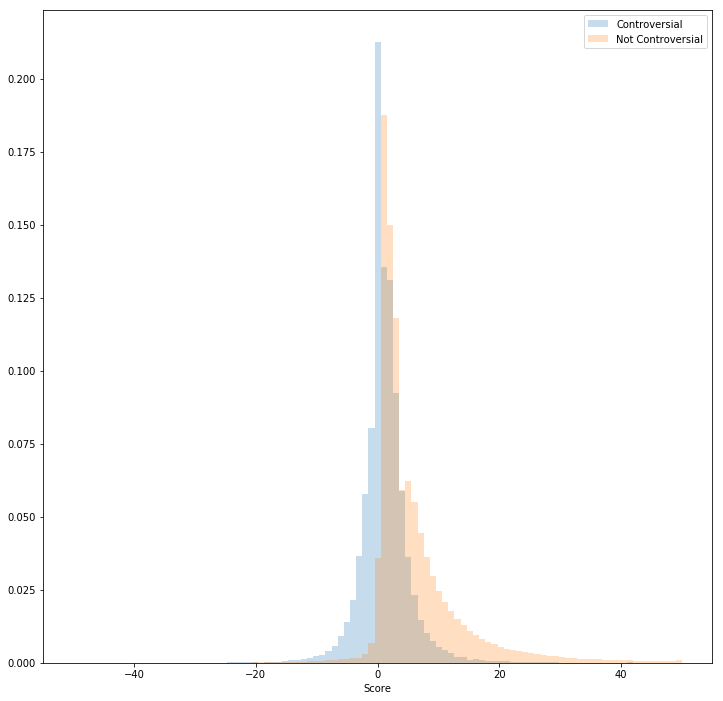

In [82]:
contro_test = hrc_comments[['controversial', 'score']]
contro = contro_test['score'][contro_test['controversial'] == 1]
not_contro = contro_test['score'][contro_test['controversial'] == 0]


bins = np.linspace(-50, 50, 100)

plt.hist(contro, bins, alpha=0.25, label='Controversial', normed=True)
plt.hist(not_contro, bins, alpha=0.25, label='Not Controversial', normed=True)
plt.xlabel("Score")
plt.legend(loc='upper right')
plt.show()

OK, it looks like controversy does not have much of an effect, and naturally, controversial comments are less likely to have high scores.

## Let's Parse Some Text!

In [83]:
_STOPWORDS = frozenset(CountVectorizer(stop_words="english").get_stop_words())
_PUNCTUATION = frozenset("".join(string.punctuation))
_MULTISPACE = re.compile(r' +')
_URL = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
_ELLIPSES = re.compile(r'[.]{2,}')

def make_bow(text_string):
    """Converts text into a bag-of-words representation used by Scikit-learn.

    Scikit-learn requires bags of words to be a space-separeted list of tokens.

    Arguments:
        text_string: The raw text to be classified (string)

    Returns:
        Space separated string containing tokens without stopwords etc.
    """

    if not text_string or type(text_string) is not str:
        return ""
    
    # Unescape HTML entities.
    text_string = html.unescape(text_string)

    # Drop URLs.
    text_string = re.sub(_URL, ' ', text_string)
    
    # Drop internal links. 
    
    # Replace control characters.
    text_string = text_string.replace('\\n', '').replace('\\t', '')
    
    # Replace ellipses with a space.
    text_string = re.sub(_ELLIPSES, ' ', text_string)
    
    # Remove punctuation.
    text_string = "".join(ch for ch in text_string if ch not in _PUNCTUATION)
    
    # Replace redundant spaces.
    text_string = re.sub(_MULTISPACE, ' ', text_string)
    
    allwords = [word.lower() for word in text_string.split(" ") if
            word not in _PUNCTUATION]
    # return " ".join(allwords)
    return " ".join(word for word in allwords if word not in _STOPWORDS).strip()

**When somebody posts a comment, it starts with a score of 1. Let's treat scores greater than 1 as *positive* sentiment for Hillary, and scores less than 0 as *negative* sentiment for Hillary.**

In [84]:
def make_label(x):
    if x > 1:
        return 1  # Positive
    elif x < 0:
        return 0  # Negative
    else:
        return np.nan

true_labels, bow = hrc_comments['score'].apply(make_label), hrc_comments['text'].apply(make_bow)
values_to_keep = ~np.isnan(true_labels)
true_labels, bow = true_labels[values_to_keep], bow[values_to_keep]

Next, let's divide the data into a training and testing set.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(bow, true_labels, test_size=.3, random_state=0)

Now we will convert the data into a term-document matrix, with number of rows equal to the number of comments, and number of columns equal to the number of words. Then, we will turn the counts into a TF-IDF score, which measures how informative or discriminative a feature is in a comment.

We would want to do this for words/unigrams, bigrams, trigrams and 4-grams, but for now we will just use words.

Misspellings and nonsense utterings plague this type of data, so we should remove words that appear seldom, and also context-specific stopwords like "clinton", but for this demo we will remove works that appear less than 100 times, and words that appear in more than 5% of comments.

In [86]:
vect_hrc = CountVectorizer(min_df=100, max_df=0.05)
X_train_counts = vect_hrc.fit_transform(X_train, y_train)
tf_transformer_hrc = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer_hrc.transform(X_train_counts)

In [87]:
X_train_tf

<591867x7489 sparse matrix of type '<class 'numpy.float64'>'
	with 6328293 stored elements in Compressed Sparse Row format>

#### Feature Selection 

We won't focus on feature selection, but I just want to show what features are determined to be significant. Let's use the chi-squared test (chi-squared feature selection) to rank the features. **We won't actually reduce the feature set though, to save time.***

In [88]:
fs = chi2(X_train_tf, y_train)
sum(fs[1] < 0.05)

992

About 992 words are statistically significant.

Let's take the chi squared value, which is the first array returned, as well as the feature names and sort by the chi-squared value.

In [89]:
chisq_value, _ = fs
words = vect_hrc.get_feature_names()
feature_df = pd.DataFrame({
    'feature': words,
    'chisq': chisq_value
})
feature_df.sort_values('chisq', ascending=False, inplace=False).head(50)

,chisq,feature
1405,590.295138,comment
7167,521.860826,violates
5585,452.112559,removed
4816,409.407819,participating
5583,394.638085,removal
5703,335.273645,rhillaryclinton
5801,300.549446,rule
3196,280.076260,hi
4235,239.936878,messages
6494,226.702019,subthis


Now let's train a Naive Bayes classifier and see how well it does. First we transform the testing data using the same transformations we used on the training data.

In [90]:
X_test_counts = vect_hrc.transform(X_test)
X_test_tf = tf_transformer_hrc.transform(X_test_counts)

### Train a Naive Bayes model.

In [91]:
clf_hrc = MultinomialNB().fit(X_train_tf, y_train)

Next, we make predictions using the trained model.

In [92]:
predictions = clf_hrc.predict_proba(X_test_tf)

We can see our error rate using a confusion matrix. **Since the data are highly imbalanced, we do not use accuracy. Instead we want to pick an optimal threshold (a posterior probability) and use that threshold from the ROC curve to label observations as 1 and 0**.

In [93]:
y_train.value_counts() / sum(y_train.value_counts())

1.0    0.960763
0.0    0.039237
Name: score, dtype: float64

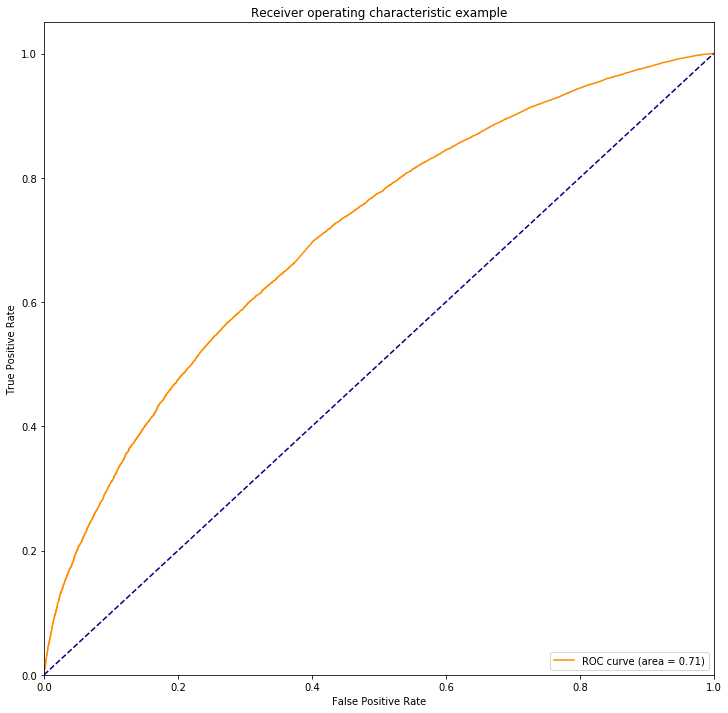

In [94]:
fpr, tpr, thresh = roc_curve(y_test, predictions[:,1])

plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

We find the optimal threshold by using the point closest to the ideal case, the top left corner.

In [95]:
roc_df = pd.DataFrame({
    'thresh': thresh, 
    'tpr': tpr, 
    'fpr': fpr,
    'distance': np.sqrt((1 - tpr)**2 + fpr**2)
})
optimal_thresh = roc_df.ix[roc_df['distance'].argmin()]
optimal_thresh['thresh']

0.96310665627799885

Now we use the threshold to compute the confusion matrix.

In [96]:
optimal = optimal_thresh['thresh']
y_predicted = (predictions[:,1] > optimal).astype(np.int8)
cm = confusion_matrix(y_test, y_predicted).astype(np.float64)
cm  # True Positives, False Negatives, False Positives, True Negatives
# Columns are predicted, rows are actual.

array([[   6606.,    3294.],
       [  91309.,  152449.]])

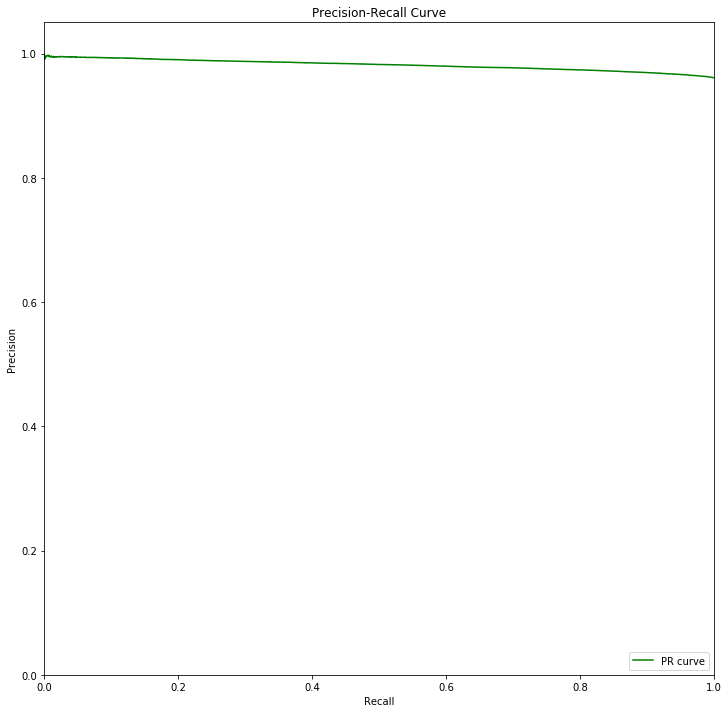

In [97]:
predictions = clf_hrc.predict_proba(X_test_tf)
p, r, _ = precision_recall_curve(y_test, predictions[:,1])

plt.plot(r, p, color='green',
         label='PR curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## Let's Look at Posts in the Bernie Sanders (/r/SandersForPresident) Subreddit

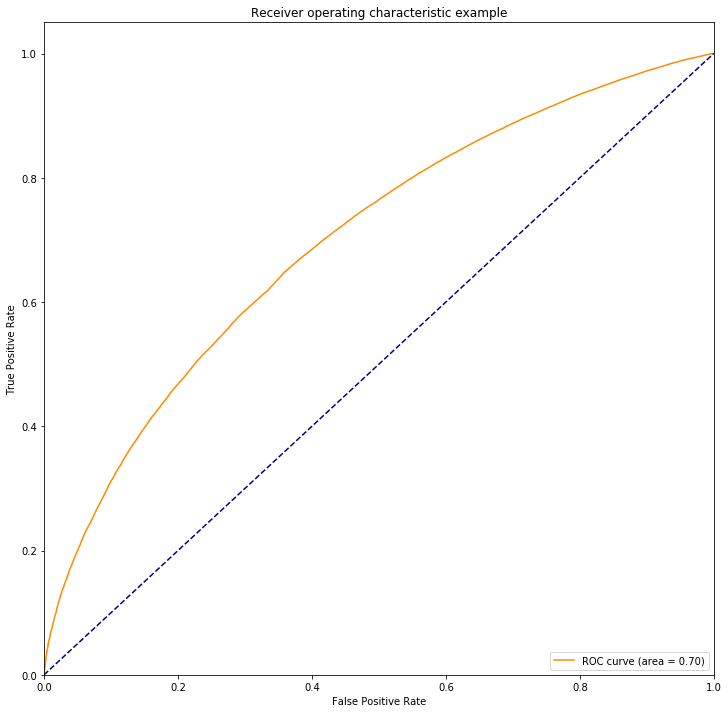

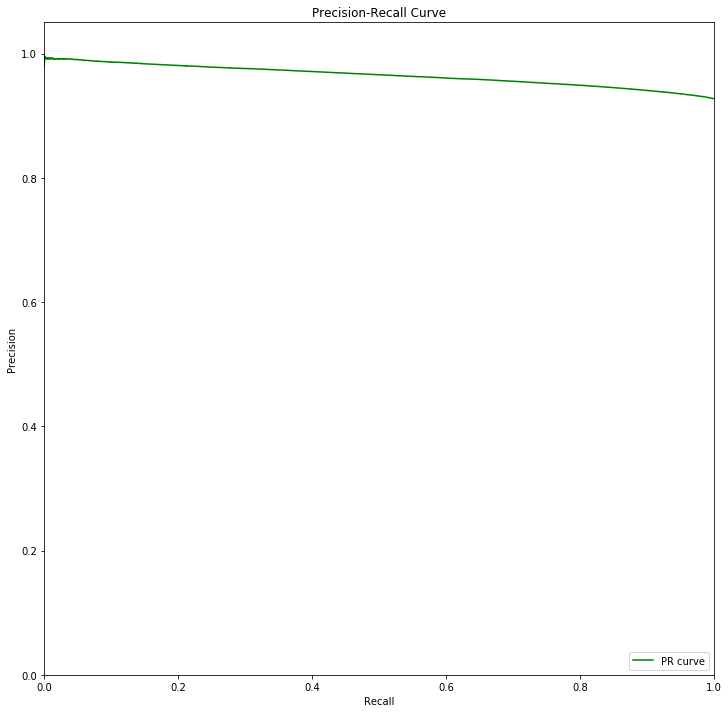

In [101]:
bs_comments = comments[comments['subreddit'] == 'SandersForPresident']
bs_comments = bs_comments[['score', 'flair', 'controversial', 'text']]

true_labels, bow = bs_comments['score'].apply(make_label), bs_comments['text'].apply(make_bow)
values_to_keep = ~np.isnan(true_labels)
true_labels, bow = true_labels[values_to_keep], bow[values_to_keep]

X_train, X_test, y_train, y_test = train_test_split(bow, true_labels, test_size=.3, random_state=0)

vect_bs = CountVectorizer(min_df=100, max_df=0.05)
X_train_counts = vect_bs.fit_transform(X_train, y_train)
tf_transformer_bs = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer_bs.transform(X_train_counts)

X_test_counts = vect_bs.transform(X_test)
X_test_tf = tf_transformer_bs.transform(X_test_counts)

clf_bs = MultinomialNB().fit(X_train_tf, y_train)

predictions = clf_bs.predict_proba(X_test_tf)
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

p, r, _ = precision_recall_curve(y_test, predictions[:,1])

plt.plot(r, p, color='green',
         label='PR curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## Let's Look at Posts in the Donald Trump (/r/The_Donald) Subreddit

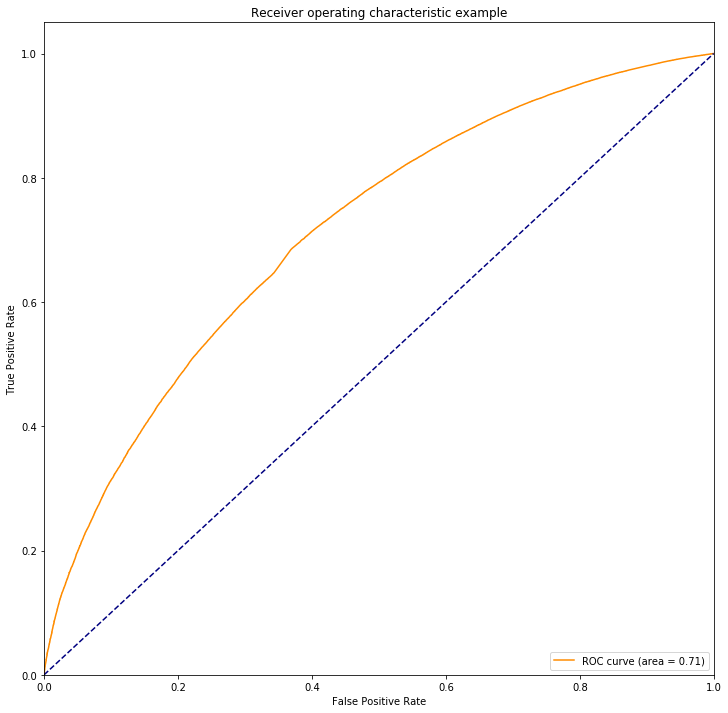

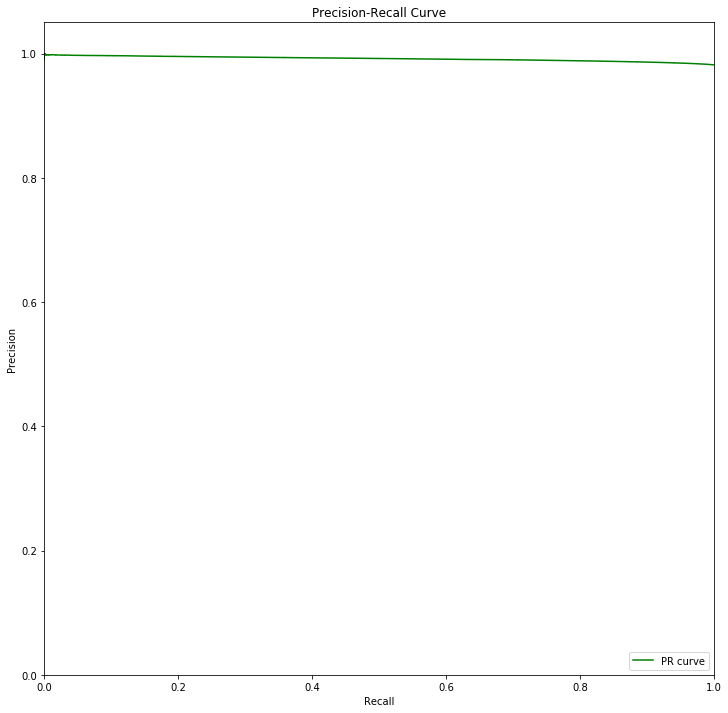

In [102]:
djt_comments = comments[comments['subreddit'] == 'The_Donald']
djt_comments = djt_comments[['score', 'flair', 'controversial', 'text']]

true_labels, bow = djt_comments['score'].apply(make_label), djt_comments['text'].apply(make_bow)
values_to_keep = ~np.isnan(true_labels)
true_labels, bow = true_labels[values_to_keep], bow[values_to_keep]

X_train, X_test, y_train, y_test = train_test_split(bow, true_labels, test_size=.3, random_state=0)

vect_djt = CountVectorizer(min_df=100, max_df=0.05)
X_train_counts = vect_djt.fit_transform(X_train, y_train)
tf_transformer_djt = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer_djt.transform(X_train_counts)

X_test_counts = vect_djt.transform(X_test)
X_test_tf = tf_transformer_djt.transform(X_test_counts)

clf_djt = MultinomialNB().fit(X_train_tf, y_train)

predictions = clf_djt.predict_proba(X_test_tf)
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

predictions = clf_djt.predict_proba(X_test_tf)
p, r, _ = precision_recall_curve(y_test, predictions[:,1])

plt.plot(r, p, color='green',
         label='PR curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# END